In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]= ":4096:8"
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
set_seed(44)
    

In [2]:
corpus = """
    perro gato ratón pájaro .
    manzana naranja pera uva .
    azul rojo verde amarillo .
    guitarra piano violín flauta .
    perro gato .
    uva pera manzana .
    amarillo rojo .
    piano violín .
    ratón pájaro gato .
    verde azul amarillo uva .
    perro .
    naranja .
    azul piano verde .
    flauta guitarra .
    gato ratón perro .
    manzana naranja uva pera .
    rojo amarillo azul .
    violín piano flauta .
    pájaro ratón gato perro .
    uva manzana naranja .
    verde azul .
    guitarra violín piano .
    perro pájaro .
    pera uva manzana naranja .
    amarillo verde rojo azul .
    flauta piano .
    gato ratón pájaro .
    naranja uva manzana pera .
    azul rojo verde .
    violín flauta guitarra piano .
"""

In [3]:
corpus = corpus.split()
word_list = list(set(corpus))
word_index = {w:i for i ,w in enumerate(word_list)}
index_word = {i:w for i ,w in enumerate(word_list)}
voc_size = len(word_list)
print(f"word_index = {word_index}")
print(f"index_word = {index_word}")
print(f"voc_size = {voc_size}")


word_index = {'ratón': 0, 'naranja': 1, 'verde': 2, 'pájaro': 3, 'violín': 4, '.': 5, 'flauta': 6, 'amarillo': 7, 'uva': 8, 'azul': 9, 'manzana': 10, 'perro': 11, 'rojo': 12, 'pera': 13, 'piano': 14, 'guitarra': 15, 'gato': 16}
index_word = {0: 'ratón', 1: 'naranja', 2: 'verde', 3: 'pájaro', 4: 'violín', 5: '.', 6: 'flauta', 7: 'amarillo', 8: 'uva', 9: 'azul', 10: 'manzana', 11: 'perro', 12: 'rojo', 13: 'pera', 14: 'piano', 15: 'guitarra', 16: 'gato'}
voc_size = 17


In [4]:
k=2 
skip_grams_positive =[]
for i in range(1,len(corpus)-1):
    target = word_index[corpus[i]]
    context = [word_index[corpus[i-1]],word_index[corpus[i+1]]]
    for c in context:
        skip_grams_positive.append([target,c])
skip_grams_negative = []
for i in range(len(corpus)):
    target = word_index[corpus[i]]
    pos_context= set()
    if i-1>=0:
        pos_context.add(corpus[i-1])
    if i+1<len(corpus):
        pos_context.add(corpus[i+1])
    candicates = [w for w in word_list if w!=corpus[i] and w not in pos_context]
    neg_word = random.sample(candicates,2*k)
    for nw in neg_word:
        skip_grams_negative.append([target,word_index[nw]])

print(f"Some positive samples: {skip_grams_positive[:3]}")
print(f"Some negative samples: {skip_grams_negative[:3]}")
print(f"Some positive samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_positive[:3]])}")
print(f"Some negative samples with tokens: {', '.join([f'({index_word[i[0]]},{index_word[i[1]]})' for i in skip_grams_negative[:3]])}")

Some positive samples: [[16, 11], [16, 0], [0, 16]]
Some negative samples: [[11, 6], [11, 8], [11, 14]]
Some positive samples with tokens: (gato,perro), (gato,ratón), (ratón,gato)
Some negative samples with tokens: (perro,flauta), (perro,uva), (perro,piano)


In [5]:
import numpy as np

def random_batch(skip_grams_positive,skip_grams_negative,batch_size):
    random_target = []
    random_context = []
    random_output = []
    positive_size = batch_size//(k+1)
    random_index = np.random.choice(range(len(skip_grams_positive)),positive_size,replace=True)
    for i in random_index:
        random_target.append(skip_grams_positive[i][0])
        random_context.append(skip_grams_positive[i][1])
        random_output.append(1)
    random_index = np.random.choice(range(len(skip_grams_negative)),positive_size*k,replace=True)
    for i in random_index:
        random_target.append(skip_grams_negative[i][0])
        random_context.append(skip_grams_negative[i][1])
        random_output.append(0)
    return random_target,random_context,random_output


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Word2Vec(nn.Module):
    def __init__(self,voc_size,embedding_size):
        super(Word2Vec,self).__init__()
        self.W = nn.Embedding(voc_size,embedding_size)
        self.C = nn.Embedding(voc_size,embedding_size)
    def forward(self,xt,xc):
        w = self.W(xt)
        c= self.C(xc)
        dot =torch.einsum('ij,ji->i',w,c.t())
        output_layer = F.sigmoid(dot)
        return output_layer

In [7]:


batch_size = 32
embedding_size =2
lr =0.01
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = Word2Vec(batch_size,embedding_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
model.train()

training_steps = 2500
eval_steps = 250
for  i in range(training_steps):
    input_w_batch, input_c_batch, target_batch = random_batch(skip_grams_positive, skip_grams_negative, batch_size)
    input_w_batch = torch.tensor(input_w_batch,dtype=torch.long).to(device)
    input_c_batch = torch.tensor(input_c_batch,dtype=torch.long).to(device)
    target_batch = torch.tensor(target_batch,dtype=torch.float32).to(device)

    labels = model(input_w_batch,input_c_batch)
    optimizer.zero_grad()
    loss = criterion(labels,target_batch)
    if i% eval_steps ==0:
        print(f"Step [{i}/{training_steps}], loss : {loss:.6f}")
    loss.backward()
    optimizer.step()
print(f'Step [{training_steps}/{training_steps}], loss: {loss.item():.6f}')
    


Step [0/2500], loss : 0.947029
Step [250/2500], loss : 0.613827
Step [500/2500], loss : 0.572903
Step [750/2500], loss : 0.429001
Step [1000/2500], loss : 0.490650
Step [1250/2500], loss : 0.426955
Step [1500/2500], loss : 0.474741
Step [1750/2500], loss : 0.494489
Step [2000/2500], loss : 0.354503
Step [2250/2500], loss : 0.368442
Step [2500/2500], loss: 0.450559


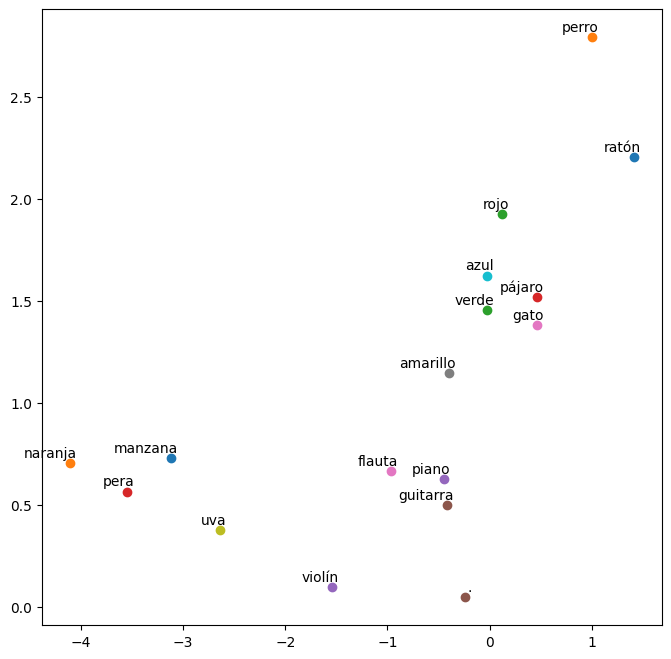

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i ,label in enumerate(word_list):
    W,C=model.parameters()
    x,y=W[i][0].item(),W[i][1].item()
    plt.scatter(x,y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

In [9]:
for name,param in model.named_parameters():
    print(f"Layer: {name} | Size : {param.size()}\n")

Layer: W.weight | Size : torch.Size([32, 2])

Layer: C.weight | Size : torch.Size([32, 2])



In [20]:
cos = nn.CosineSimilarity(dim=0)

uva = model.W(torch.tensor(word_index['uva']).to(device))
manzana = model.W(torch.tensor(word_index['manzana']).to(device))
gato = model.W(torch.tensor(word_index['gato']).to(device))

print(uva.size())
print(manzana.size())
print(gato.size())
print(f"Cosine similarity between 'uva' and 'manzana' is {cos(uva, manzana).item():.3f}")
print(f"Cosine similarity between 'uva' and 'gato' is {cos(uva, gato).item():.3f}")

torch.Size([2])
torch.Size([2])
torch.Size([2])
Cosine similarity between 'uva' and 'manzana' is 0.996
Cosine similarity between 'uva' and 'gato' is -0.180


In [22]:
import torch
A = torch.tensor([[1., 2., 3.],
                  [4., 5., 6.]])      # (2,3)

B = torch.tensor([[10., 20.],
                  [30., 40.],
                  [50., 60.]])        # (3,2)

d = torch.einsum('ij,ji->i', A, B)
print(d)
C = B.t()
d = torch.einsum('ij,ij->i',A,C)
print(d)

tensor([220., 640.])
tensor([220., 640.])


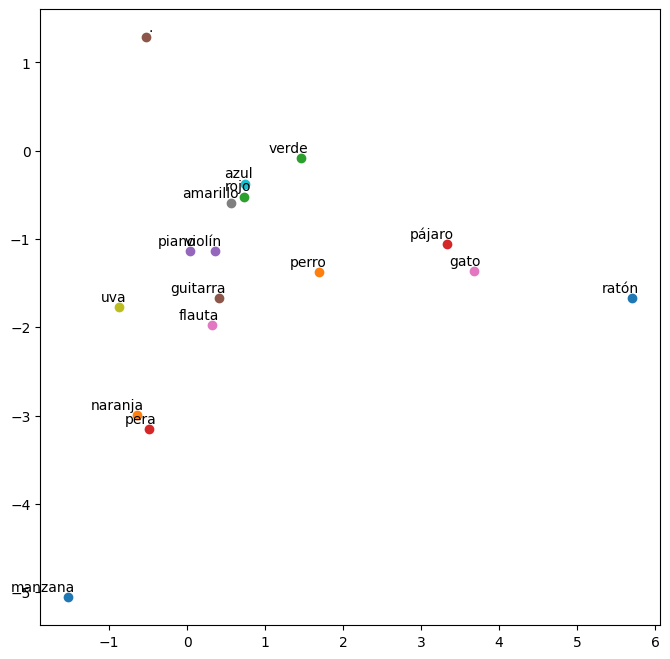

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i ,label in enumerate(word_list):
    W,C=model.parameters()
    x,y=C[i][0].item(),C[i][1].item()
    plt.scatter(x,y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

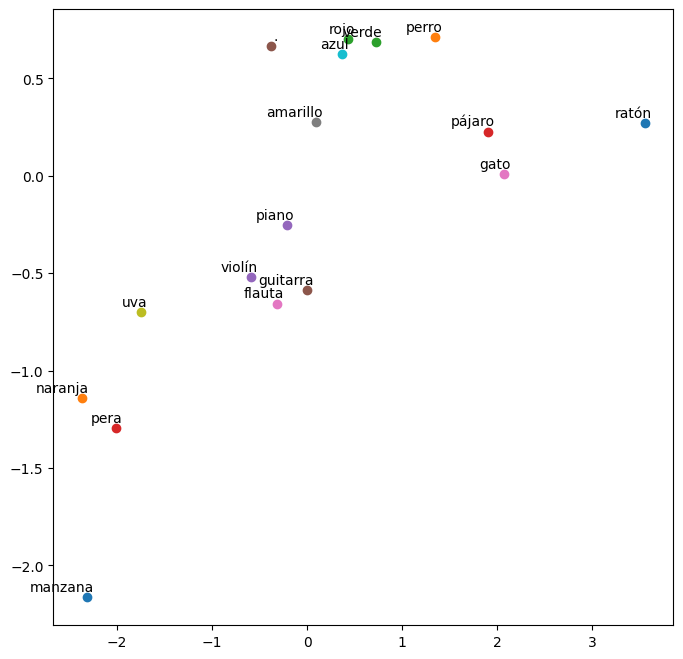

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i ,label in enumerate(word_list):
    W,C=model.parameters()
    x,y=(W[i][0].item()+C[i][0].item())/2,(W[i][1].item()+C[i][1].item())/2
    plt.scatter(x,y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')